### Notebook for comparing a squiggle chunk after resolution reduction

The notebook does:
* removal of "spikes".
* z-score normalisation.
* resolution reduction by assigning single values to stretches of the squiggle that vary below a certain threshold.
* "time normalisation" by just removing any consecutively repeating values from the reduced resolution representation.
* comparison of a sample chunk against the other squiggle which is known to be similar (with seeimingly good results!).

*The "time normalisation" technique will cause issues if there is a section of a squiggle that actually is a single value as this will just be considered as a single entry.*
* The resolution reduction technique is lossy but the potential usefulness lies in the fact that it is *consistently* lossy. If comparisons of the reduced resolution squiggles is faster than the NN approach, then we can use it to quickly reduce the set of squiggles that the NN has to compare.

In [64]:
import time
from ont_fast5_api.fast5_interface import get_fast5_file
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [65]:
def loadReads(f5_file="../../similar_testdata/similar_squiggles.fast5", withMetadata=False):
    '''
        returns list of numpy arrays representing reads as well as dataframe containing reads metadata.
    '''
    print("reading squiggles file...")
    start = time.time()
    reads = []
    if withMetadata:
        ids = []
        length = []
        with get_fast5_file(f5_file, mode="r") as f5:
            for read in f5.get_reads():
                raw_data = read.get_raw_data()
                reads.append(raw_data)
                ids.append(read.read_id)
                length.append(len(raw_data))

        z = list(zip(ids, length))
        print(f"Took {time.time()-start} seconds.\n")
        return reads, pd.DataFrame(z, columns=["id", "length"])

    else:
        with get_fast5_file(f5_file, mode="r") as f5:
            for read in f5.get_reads():
                raw_data = read.get_raw_data()
                reads.append(raw_data)
        print(f"Took {time.time()-start} seconds.\n")
        return reads

In [66]:
def zScoreNormalise(sequence):
    zScoreNormalised = np.zeros(len(sequence))
    mean = np.mean(sequence)
    standardDev = np.std(sequence)
    zScoreNormalised = (sequence - mean) / standardDev
    return zScoreNormalised

In [67]:
allSquiggles, metadata = loadReads(withMetadata=True)

reading squiggles file...
Took 5.152466535568237 seconds.



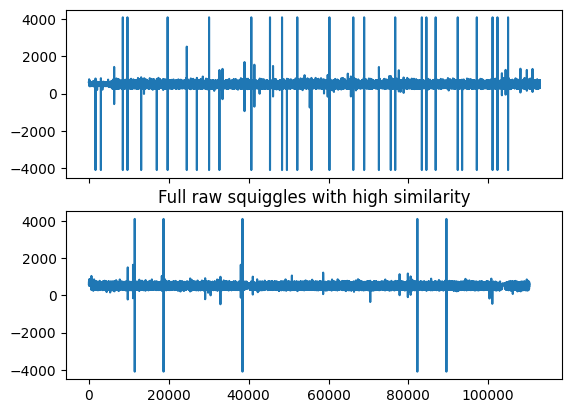

In [68]:
compNo = 2      #no. of squiggles being compared
similarSquiggles = ["995e06ac-fb8c-4c67-a783-223583c215bd", "4d1b87b0-a975-4520-bd89-40e8dd0dd185"]
similarIndices = metadata.index[(metadata['id']==similarSquiggles[0]) | (metadata['id']==similarSquiggles[1])].tolist()

copiedSquiggles = [allSquiggles[similarIndices[i]].copy() for i in range(compNo)]


fig1, axs = plt.subplots(compNo, sharex=True)
plt.title("Full raw squiggles with high similarity")
for i in range(compNo):
    axs[i].plot(copiedSquiggles[i])

plt.show()

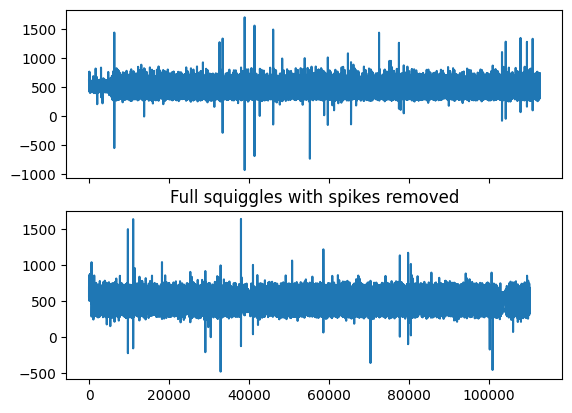

In [69]:
spikeThresh = 2000              #parameter to tweak/learn
removedSpikes = []
for i in range(compNo):
    removedSpikes.append([j for j in copiedSquiggles[i] if abs(j) < spikeThresh])

fig, axs = plt.subplots(compNo, sharex=True)
plt.title("Full squiggles with spikes removed")
for i in range(compNo):
    axs[i].plot(removedSpikes[i])

plt.show()

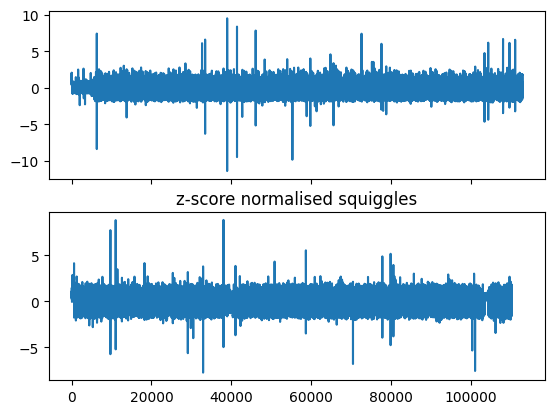

In [70]:
zScoreNormalised = [zScoreNormalise(np.array(i)) for i in removedSpikes]       #list holding the 2 squiggles that have been normalised based on the z-score

fig, axs = plt.subplots(compNo, sharex=True)
plt.title("z-score normalised squiggles")
for i in range(compNo):
    axs[i].plot(zScoreNormalised[i])

plt.show()

In [71]:
#variable used to control the resolution of the significant values approximation
thresh = 0.2            #parameter to tweak/learn

In [73]:
# Initialize an empty list to store moving averages
differences = []

for s in range(compNo):
    differences.append([])
    for i in range(len(zScoreNormalised[s])-1):
	    differences[s].append(abs(zScoreNormalised[s][i+1] - zScoreNormalised[s][i]))

    differences[s].insert(0, 0)		#inserting 0 at 0th index to compensate for shift


In [72]:
resReducedSquiggles = []
for s in range(compNo):
    resReducedSquiggles.append([])
    sig = 0
    for i in range(len(zScoreNormalised[s])):
        if differences[s][i] > thresh: sig = zScoreNormalised[s][i]
        resReducedSquiggles[s].append(sig)

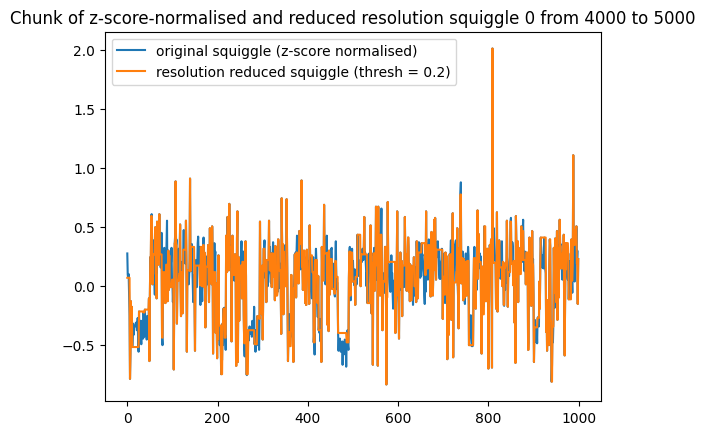

In [74]:
chunkStart = 4000
chunkSize = 1000
chunkEnd = chunkStart + chunkSize

fig = plt.figure()
plt.title(f"Chunk of z-score-normalised and reduced resolution squiggle 0 from {chunkStart} to {chunkEnd}")

plt.plot(zScoreNormalised[0][chunkStart:chunkEnd], label="original squiggle (z-score normalised)")
plt.plot(resReducedSquiggles[0][chunkStart:chunkEnd], label=f"resolution reduced squiggle (thresh = {thresh})")
plt.legend()
plt.show()

### "Time normalisation"
Basically just removing any consecutively repeating values.

length of original squiggle 0: 112910
length of time normalised squiggle 0: 27097
76.0% size reduction


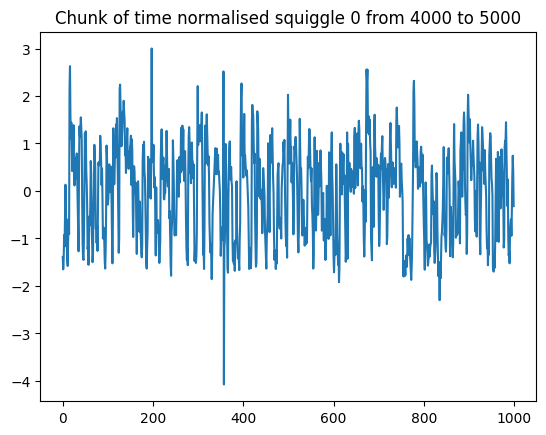

In [75]:
timeNormalised = []
for s in range(compNo):
    timeNormalised.append([])
    for i in range(1, len(resReducedSquiggles[s])):
        if resReducedSquiggles[s][i] != resReducedSquiggles[s][i-1]:
            timeNormalised[s].append(resReducedSquiggles[s][i])

print(f"length of original squiggle 0: {len(copiedSquiggles[0])}")
print(f"length of time normalised squiggle 0: {len(timeNormalised[0])}")
percentReduction = 100 - ((len(timeNormalised[0]) / len(copiedSquiggles[0]) ) * 100)
print(f"{round(percentReduction, 2)}% size reduction")


normalisedChunk = timeNormalised[0][chunkStart:chunkEnd]
fig = plt.figure()
plt.title(f"Chunk of time normalised squiggle 0 from {chunkStart} to {chunkEnd}")

plt.plot(normalisedChunk)
plt.show()

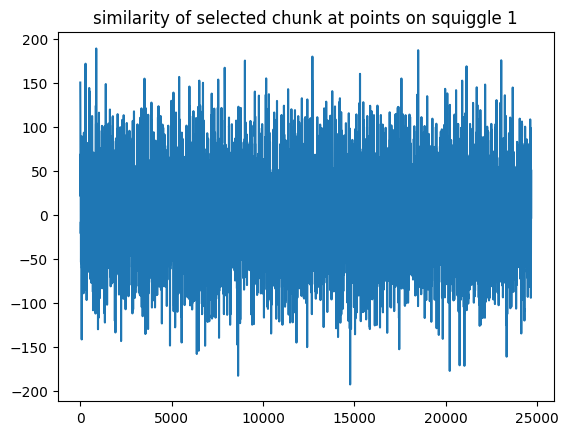

In [76]:
crossC = np.correlate(timeNormalised[1], normalisedChunk)

fig = plt.figure()
plt.title("similarity of selected chunk at points on squiggle 1")

plt.plot(crossC)
plt.show()

index of selected chunk (from squiggle 0): 4000
index of max overlap in squiggle 1: 874


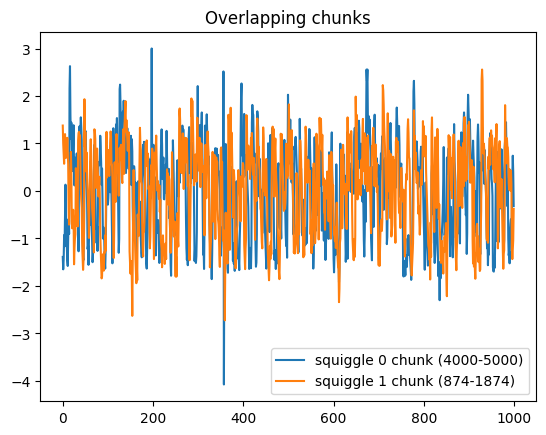

In [77]:
maxOverlap = np.argmax(crossC)
print(f"index of selected chunk (from squiggle 0): {chunkStart}")
print(f"index of max overlap in squiggle 1: {maxOverlap}")

fig = plt.figure()
plt.title("Overlapping chunks")

#plt.plot(normalisedChunk)
plt.plot(normalisedChunk, label=f"squiggle 0 chunk ({chunkStart}-{chunkEnd})")
plt.plot(timeNormalised[1][maxOverlap:maxOverlap+chunkSize], label=f"squiggle 1 chunk ({maxOverlap}-{maxOverlap+chunkSize})")
plt.legend()
plt.show()


### CC Validation
 Just showing that the cross correlation can locate the chunk within the squiggle it came from.

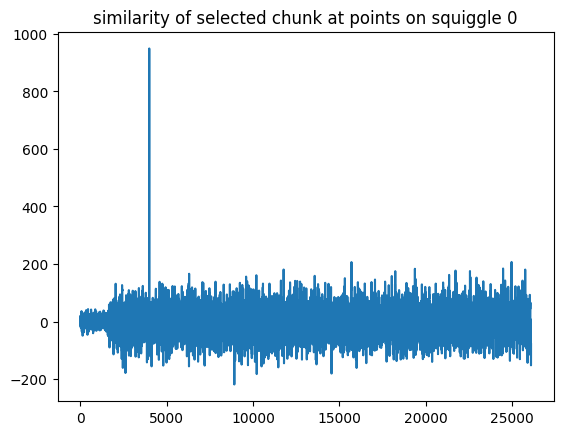

In [78]:
valCrossC = np.correlate(timeNormalised[0], normalisedChunk)

fig = plt.figure()
plt.title("similarity of selected chunk at points on squiggle 0")

plt.plot(valCrossC)
plt.show()

index of selected chunk (from squiggle 0): 4000
detected mad match index: 4000


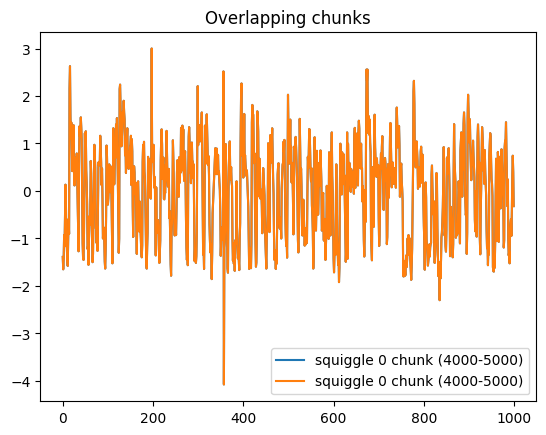

In [79]:
maxOverlap = np.argmax(valCrossC)
print(f"index of selected chunk (from squiggle 0): {chunkStart}")
print(f"detected mad match index: {maxOverlap}")

fig = plt.figure()
plt.title("Overlapping chunks")

#plt.plot(normalisedChunk)
plt.plot(normalisedChunk, label=f"squiggle 0 chunk ({chunkStart}-{chunkEnd})")
plt.plot(timeNormalised[0][maxOverlap:maxOverlap+chunkSize], label=f"squiggle 0 chunk ({maxOverlap}-{maxOverlap+chunkSize})")
plt.legend()
plt.show()